#### Wasserstein GANS with Gradient penality (WGAN - GP)

1.  Here we will some of the stability issues with the GANs that we have been using till the point.
2. Here we use the W-loss as a criterion.
3. we will use the critic that score the images with the real images not 0/1 where we used for previous gans.



In [1]:
### importing modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

**Generator and Noise**

In [2]:
from tensorflow.python.ops.gen_nn_ops import Relu
from keras.engine.base_layer import Layer
from keras.api._v2.keras import activations
## creating the generator class
class Generator(tf.keras.Model):

  def __init__(self, z_dim = 100, hidden_dim = 64, **kwargs):
    super().__init__(**kwargs)
    self.proj_reshape = self.project_resample(2*2*100, (2,2,100))
    self.gen_block1 = self.make_gen_block(hidden_dim, 3,2,"same")
    self.gen_block2 = self.make_gen_block(hidden_dim//2, 3, 2, "same")
    self.gen_block3 = self.make_gen_block(hidden_dim//4, 5,2, "valid")
    self.gen_block4 = self.make_gen_block(hidden_dim//8, 5, 1, "valid")
    self.image_gen = self.make_gen_block(1, 6, 1, "valid", final_layer=True)


  def call(self, inputs):
    x = self.proj_reshape(inputs)
    x = self.gen_block1(x)
    x = self.gen_block2(x)
    x = self.gen_block3(x)
    x = self.gen_block4(x)
    x = self.image_gen(x)
    return x

  def make_gen_block(self, filters, kernel_size=3, stride=2,padding = "same", final_layer=False):
    if not final_layer:
      return keras.Sequential([
          keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides = stride, padding = padding),
          keras.layers.BatchNormalization(),
          keras.layers.Activation("relu")
      ])

    else:
      return keras.Sequential([
          keras.layers.Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = stride, padding = padding),
          keras.layers.Activation("tanh")
      ])


  def project_resample(self, out_dims, target_shape):
    return keras.Sequential([
        keras.layers.Dense(out_dims, activation = "relu"),
        keras.layers.Reshape(target_shape = target_shape)
    ])

### Generating the Random Noise
def generate_noise(num_samples, dims):
  return tf.random.normal( shape = (num_samples, dims))


In [3]:
### sanity-check
noise = generate_noise(1, 100)
gen_net = Generator()
out = gen_net(noise)
out.shape

TensorShape([1, 28, 28, 1])

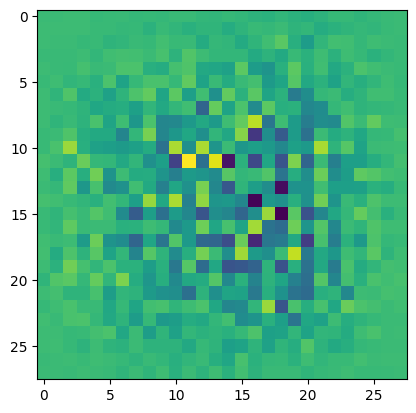

In [4]:
plt.imshow(out[0])

**Critic ( a Discriminator)**

In [5]:

class discriminator_block(keras.layers.Layer):
  '''
    Discriminator Block
    --------------------
    > Convolution2D
    > we will high stride.
    > Batch Normalization
    > Activation
  '''

  def __init__(self,filters, kernel_size, strides, **kwargs):
    super().__init__(**kwargs)
    self.conv = keras.layers.Conv2D(filters, kernel_size, strides, padding = "same")
    self.batch_norm = keras.layers.BatchNormalization()
    self.activation = keras.layers.Activation("relu")

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.batch_norm(x)
    x = self.activation(x)
    return x



class Discriminator(keras.Model):
  '''
    || Discriminator Layers
    >> Lay 1: Block : Conv2d layers -> batch norm -> activation
    >> Global averaging
    >> Dense Layer for classification
  '''

  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.disc_block1 = discriminator_block(filters = 16, kernel_size = 3, strides = 2)
    self.disc_block2 = discriminator_block(filters = 32, kernel_size =3, strides = 2)
    self.disc_block3 = discriminator_block(filters = 64, kernel_size = 3, strides = 2)
    self.disc_block4 = discriminator_block(filters = 128, kernel_size = 3, strides = 2)
    self.global_average = keras.layers.GlobalAvgPool2D()
    self.classifier = keras.layers.Dense(1)



  def call(self, inputs):
    x = self.disc_block1(inputs)
    x = self.disc_block2(x)
    x = self.disc_block3(x)
    # x = self.disc_block4(x)
    x = self.global_average(x)
    x = self.classifier(x)

    return x



In [6]:
### sanity-checks
sampl_img = tf.random.normal(shape=(128, 28,28,1))
disc_net = Discriminator()
out = disc_net(sampl_img)

out.shape

TensorShape([128, 1])

**Gradient Penalty**
- Gradient penality we will use when we want the Wasstertain metric as a loss functin.
- W-loss must be in 1-Lipstance continuity. i.e norms of the gradent has atmost 1.

**Calculating gradient penality can be broken into 2 functiokns**
- Compute the gradient w.r.t the images
- Compute the gradient penality given the gradient.



In [7]:

def compute_gradients(critic , real_image, fake_image, epsilon):

  mixed_image = epsilon* real_image + (1-epsilon)*fake_image
  with tf.GradientTape() as tape:
    tape.watch(mixed_image)
    mixed_score = critic(mixed_image)

  grads = tape.gradient(mixed_score, mixed_image)

  return grads

In [8]:
### sanity checks

def test_compute_gradients(image_shape):
  real_image = tf.random.normal(shape = image_shape)
  fake_image = tf.random.normal(shape = image_shape)
  epsilon = tf.random.normal((image_shape[0], 1,1,1))
  grads = compute_gradients(disc_net, real_image, fake_image, epsilon)

  assert grads.shape == image_shape
  assert tf.reduce_max(grads[0]) > 0
  assert tf.reduce_min(grads[0]) < 0
  return grads[0]

gradients = test_compute_gradients((2,28,28,1))
print("Succuss")


Succuss


**Gradient Penality**

In [9]:
## computing the gradient penalities
def gradient_penality(gradient):
  '''
    here we are computing the gradient penality
  '''
  grads_norm = tf.norm(gradient, ord = 2)
  penality = tf.reduce_mean((grads_norm -1)**2)
  return penality

In [10]:
### sanity-check for the gradient penality checking
def test_gradient_penality(image_shape):
  '''
    step 1: compute the gradient w.rt. inputs
    step 2: Compute the penality based on the gradients.

    ## here will check for the bad gradients, good gradients, normal gradients
    >> Generally the gradient penality is high then they are bad gradients i.e penality is close to one.
    >> If the penality is low , then those are good gradients i.e penality need to near zero
  '''
  bad_grads = tf.cast(tf.zeros_like(image_shape), dtype = tf.float32) ## there is no improvement of the model (i.e gradients are vanished)
  bad_penality = gradient_penality(bad_grads)


  good_grads = tf.cast(tf.ones_like(image_shape), dtype = tf.float32)/ tf.cast(tf.math.reduce_sum(image_shape), dtype = tf.float32)
  good_penality = gradient_penality(good_grads)


  grads = test_compute_gradients(image_shape)
  penality = gradient_penality(grads)

  return bad_penality, good_penality, penality

In [11]:
bp, gp, pp = test_gradient_penality((2, 28, 28, 1))

print("Bad gradient penality : ", bp)
print("Good gradient penality : ", gp)
print("General gradient penality : ", pp)



Bad gradient penality :  tf.Tensor(1.0, shape=(), dtype=float32)
Good gradient penality :  tf.Tensor(0.9333525, shape=(), dtype=float32)
General gradient penality :  tf.Tensor(0.94667745, shape=(), dtype=float32)


**Losses**


Generator Loss

       - Here we will maximize the critic score.

Critic:

        - For the critic we will maximize the distance between the critic score for real image and critic score for fake image and also we add the gradient penality to the loss to be have a valid W-Loss.



In [12]:
### generator Loss
def generator_loss(critic_preds):
  gen_loss = -1 *tf.reduce_mean(critic_preds)
  return gen_loss


### Discriminator Loss
def critic_loss(real_critic_scores, fake_critic_scores, gp, gp_lambda):
  cri_loss = tf.reduce_mean(real_critic_scores) - tf.reduce_mean(fake_critic_scores) + gp_lambda*gp
  return cri_loss


**Loading Dataset**

In [13]:
### loading the dataset
(x_train_2, y_train_2), (x_val_2, y_val_2) = keras.datasets.mnist.load_data()

### Getting the overview for the dataset
print("Shapes of the training dataset : ", x_train_2.shape, y_train_2.shape)
print("Shapes of the validation dataset : ",x_val_2.shape, y_val_2.shape)

11490434/11490434 [==============================] - 0s 0us/step
Shapes of the training dataset :  (60000, 28, 28) (60000,)
Shapes of the validation dataset :  (10000, 28, 28) (10000,)


### **Creating the Data loaders**

In [14]:
## Configurations
batch_size = 128



### reshaping the training  and validation dataset
# x_train = x_train/255
x_train = np.expand_dims((x_train_2-255)/255, axis = -1)
y_train = np.expand_dims(y_train_2, axis = -1)

### Data Loaders

## converting the features in to the tensors
features = tf.convert_to_tensor(x_train)
labels = tf.convert_to_tensor(y_train)

features = tf.cast(features, dtype="float32")

dataloaders = tf.data.Dataset.from_tensor_slices((features, labels))
dataloaders = dataloaders.batch(batch_size)

In [15]:
### Initializing the networks
gen_network = Generator()
disc_network = Discriminator()

**Training the Network**

In [16]:
## defining the configurations
learn_rate = 0.0001

### initializing losses and optimizers
gen_optimizer = keras.optimizers.Adam(learning_rate = learn_rate)
critic_optimizer = keras.optimizers.Adam(learning_rate = learn_rate)

### traning the network

In [23]:
generator_repeat =3
critic_repeat = 5


### training step updating the gradient and checking the results
def train_step(fake_noise, real_image):

  ### training the critic Network
  total_disc_loss = 0
  for _ in range(critic_repeat):
    with tf.GradientTape() as cri_tape:
      ## noise > image > gp (epsilon) > critc_score
      fake_noise = generate_noise(len(real_image), 100)
      fake_img = gen_network(fake_noise)
      critic_fake_score = disc_network(fake_img)
      critic_real_score = disc_network(real_image)

      epsilion = tf.random.normal((len(real_image), 1, 1, 1))
      grads = compute_gradients(disc_network, real_image, fake_img, epsilion)

      ## get gradient penality
      gp = gradient_penality(grads)
      lambda_ = 10
      cri_loss = critic_loss(critic_fake_score, critic_real_score, gp, lambda_)
      total_disc_loss +=cri_loss/critic_repeat

    disc_grads = cri_tape.gradient(cri_loss, disc_network.trainable_variables)
    critic_optimizer.apply_gradients(zip(disc_grads, disc_network.trainable_variables))


  total_gen_loss = 0
  for _ in range(generator_repeat):
    with tf.GradientTape() as gen_tape:
      ## noise > image > gp (epsilon) > critc_score
      fake_noise = generate_noise(len(real_image), 100)
      fake_img = gen_network(fake_noise)
      critic_fake_score = disc_network(fake_img)

      gen_loss = generator_loss(critic_fake_score)
      total_gen_loss +=gen_loss/generator_repeat

    gen_grads = gen_tape.gradient(gen_loss, gen_network.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, gen_network.trainable_variables))

  return total_gen_loss, total_disc_loss


In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


Epoch : 1/10


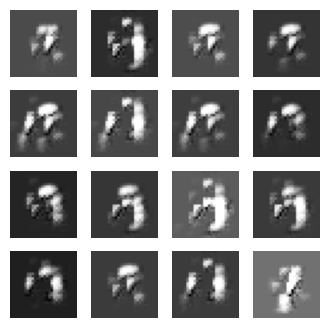

|| Generator Loss : 0.8311189413070679 , Discriminator Loss -0.1591905653476715
Epoch : 2/10


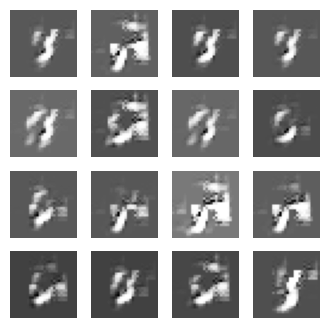

|| Generator Loss : 0.6629505753517151 , Discriminator Loss -0.20738336443901062
Epoch : 3/10


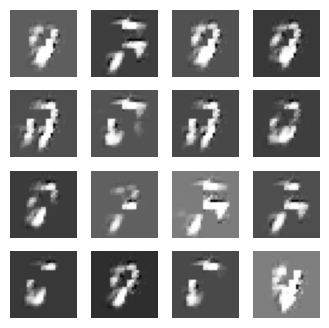

|| Generator Loss : 0.8545240163803101 , Discriminator Loss -0.21640801429748535
Epoch : 4/10


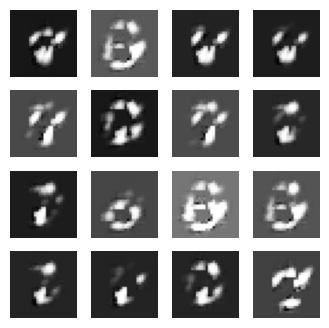

|| Generator Loss : 1.1509289741516113 , Discriminator Loss -0.17516133189201355
Epoch : 5/10


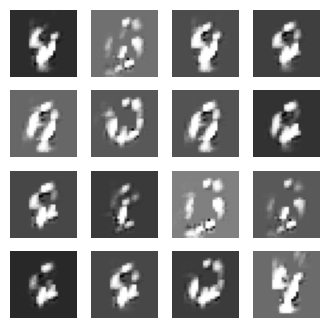

|| Generator Loss : 1.0875842571258545 , Discriminator Loss -0.15393763780593872
Epoch : 6/10


In [ ]:
### training the Network
epochs = 10
steps =0
seed = tf.random.normal([16, 100])
for epoch in range(epochs):
  print("Epoch : {}/{}".format(epoch+1, epochs))

  for real_image,_ in dataloaders:

    if(len(real_image)<batch_size):
      continue
    steps += 1
    fake_noise = generate_noise(batch_size, 100)
    gen_loss, disc_loss = train_step(fake_noise, real_image)



  generate_and_save_images(gen_network,
                           epoch,
                           seed)
  print("|| Generator Loss : {} , Discriminator Loss {}".format(gen_loss, disc_loss))